In [3]:
import pandas as pd
import geopandas as gp
from rasterstats import zonal_stats
from affine import Affine
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
from osgeo import gdal
from descartes import PolygonPatch
import datetime
from __future__ import print_function
pd.set_option('io.hdf.default_format', 'table')
%matplotlib inline

/home/nathan/venvs/main/local/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


,ADM0_NAME,ADM1_NAME,ADM2_NAME,Adm_Region,Shape_Area,Shape_Leng,geometry
0,Uganda,Kaabong,Dodoth,Northern,0.591806,4.145036,"POLYGON ((34.09300649600004 3.860423536000042,..."
1,Uganda,Kitgum,Lamwo,Northern,0.449351,3.599283,"POLYGON ((33.32717235000007 3.766835490000062,..."
2,Uganda,Moyo,West Moyo,Northern,0.081616,1.449875,"POLYGON ((31.82121000000006 3.821970000000022,..."
3,Uganda,Yumbe,Aringa,Northern,0.194958,2.389856,"POLYGON ((31.51588987900004 3.639262337000048,..."
4,Uganda,Kitgum,Chua,Northern,0.334961,3.690828,"POLYGON ((33.50670000100007 3.752300000000048,..."
5,Uganda,Koboko,Koboko,Northern,0.061994,1.378402,"POLYGON ((31.07686000000007 3.745340000000056,..."
6,Uganda,Adjumani,Adjumani,Northern,0.251136,2.648423,"POLYGON ((32.04523000000006 3.591670000000022,..."
7,Uganda,Gulu,Kilak,Northern,0.353261,4.608345,"POLYGON ((32.06139403100008 3.579657129000054,..."
8,Uganda,Moyo,Obongi,Northern,0.068809,1.323407,"POLYGON ((31.53577804600008 3.579788923000024,..."
9,Uganda,Arua,Maracha,Northern,0.036492,0.995651,"POLYGON ((30.92056465200005 3.362176895000061,..."


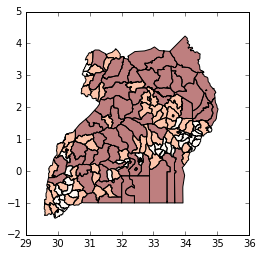

In [4]:
# TODO Clip Lake Victoria?
# https://borealperspectives.wordpress.com/2016/03/07/plotting-polygon-shapefiles-on-a-matplotlib-basemap-with-geopandas-shapely-and-descartes/
uganda_shapes = gp.GeoDataFrame.from_file("/home/nathan/Uganda_admin_2014_WGS84.shp")
uganda_shapes.plot(column='Shape_Area', scheme='QUANTILES', k=3, colormap='OrRd')
uganda_shapes

In [5]:
# An arbitrary file chosen to get coordinates for projection
file_name = "/home/nathan/GPM/201611/3B-HHR-E.MS.MRG.3IMERG.20161121-S070000-E072959.0420.V03E.RT-H5"
with h5py.File(file_name, 'r') as f:
    print("Keys:")
    for key in f['Grid'].keys():
        print(key)
    lons = np.array(f['Grid/lon'])
    lats = np.array(f['Grid/lat'])

Keys:
IRkalmanFilterWeight
HQprecipSource
lon
precipitationCal
precipitationUncal
lat
HQprecipitation
probabilityLiquidPrecipitation
HQobservationTime
randomError
IRprecipitation


In [6]:
def get_total_precipitation(start_date, end_date):
    """
    Get a numpy raster map of the total precipitation over the given date range in millimeters.
    """
    file_name_pattern = ('/home/nathan/GPM/%(year)4d%(month)02d/' +
        '3B-HHR-E.MS.MRG.3IMERG.%(year)4d%(month)02d%(day)02d-' +
        'S%(hour)02d%(minute)02d00-E%(end_hour)02d%(end_minute)02d59.%(minute_of_day)04d.V03E.RT-H5'
    )
    precip_data = None
    date_range_hours = (end_date - start_date).total_seconds() / (60 * 60)
    iterval_minutes = 30
    count = 0
    while start_date <= end_date:
        count += 1
        file_name = file_name_pattern % dict(
            year=start_date.year,
            month=start_date.month,
            day=start_date.day,
            hour=start_date.hour,
            minute=start_date.minute,
            end_hour=(start_date + datetime.timedelta(minutes=iterval_minutes - 1)).hour,
            end_minute=(start_date + datetime.timedelta(minutes=iterval_minutes - 1)).minute,
            minute_of_day=(
                start_date - datetime.datetime(start_date.year, start_date.month, start_date.day)
            ).total_seconds() / 60
        )
        #print file_name
        with h5py.File(file_name, 'r') as f:
            d = np.array(f['Grid/precipitationCal'])
            d = np.clip(d, 0, np.inf)
            if precip_data is None:
                precip_data = d
            else:
                precip_data += d
        start_date += datetime.timedelta(minutes=iterval_minutes)
    #in mm/hr
    average_precipitation_rate = precip_data / count
    return average_precipitation_rate * date_range_hours

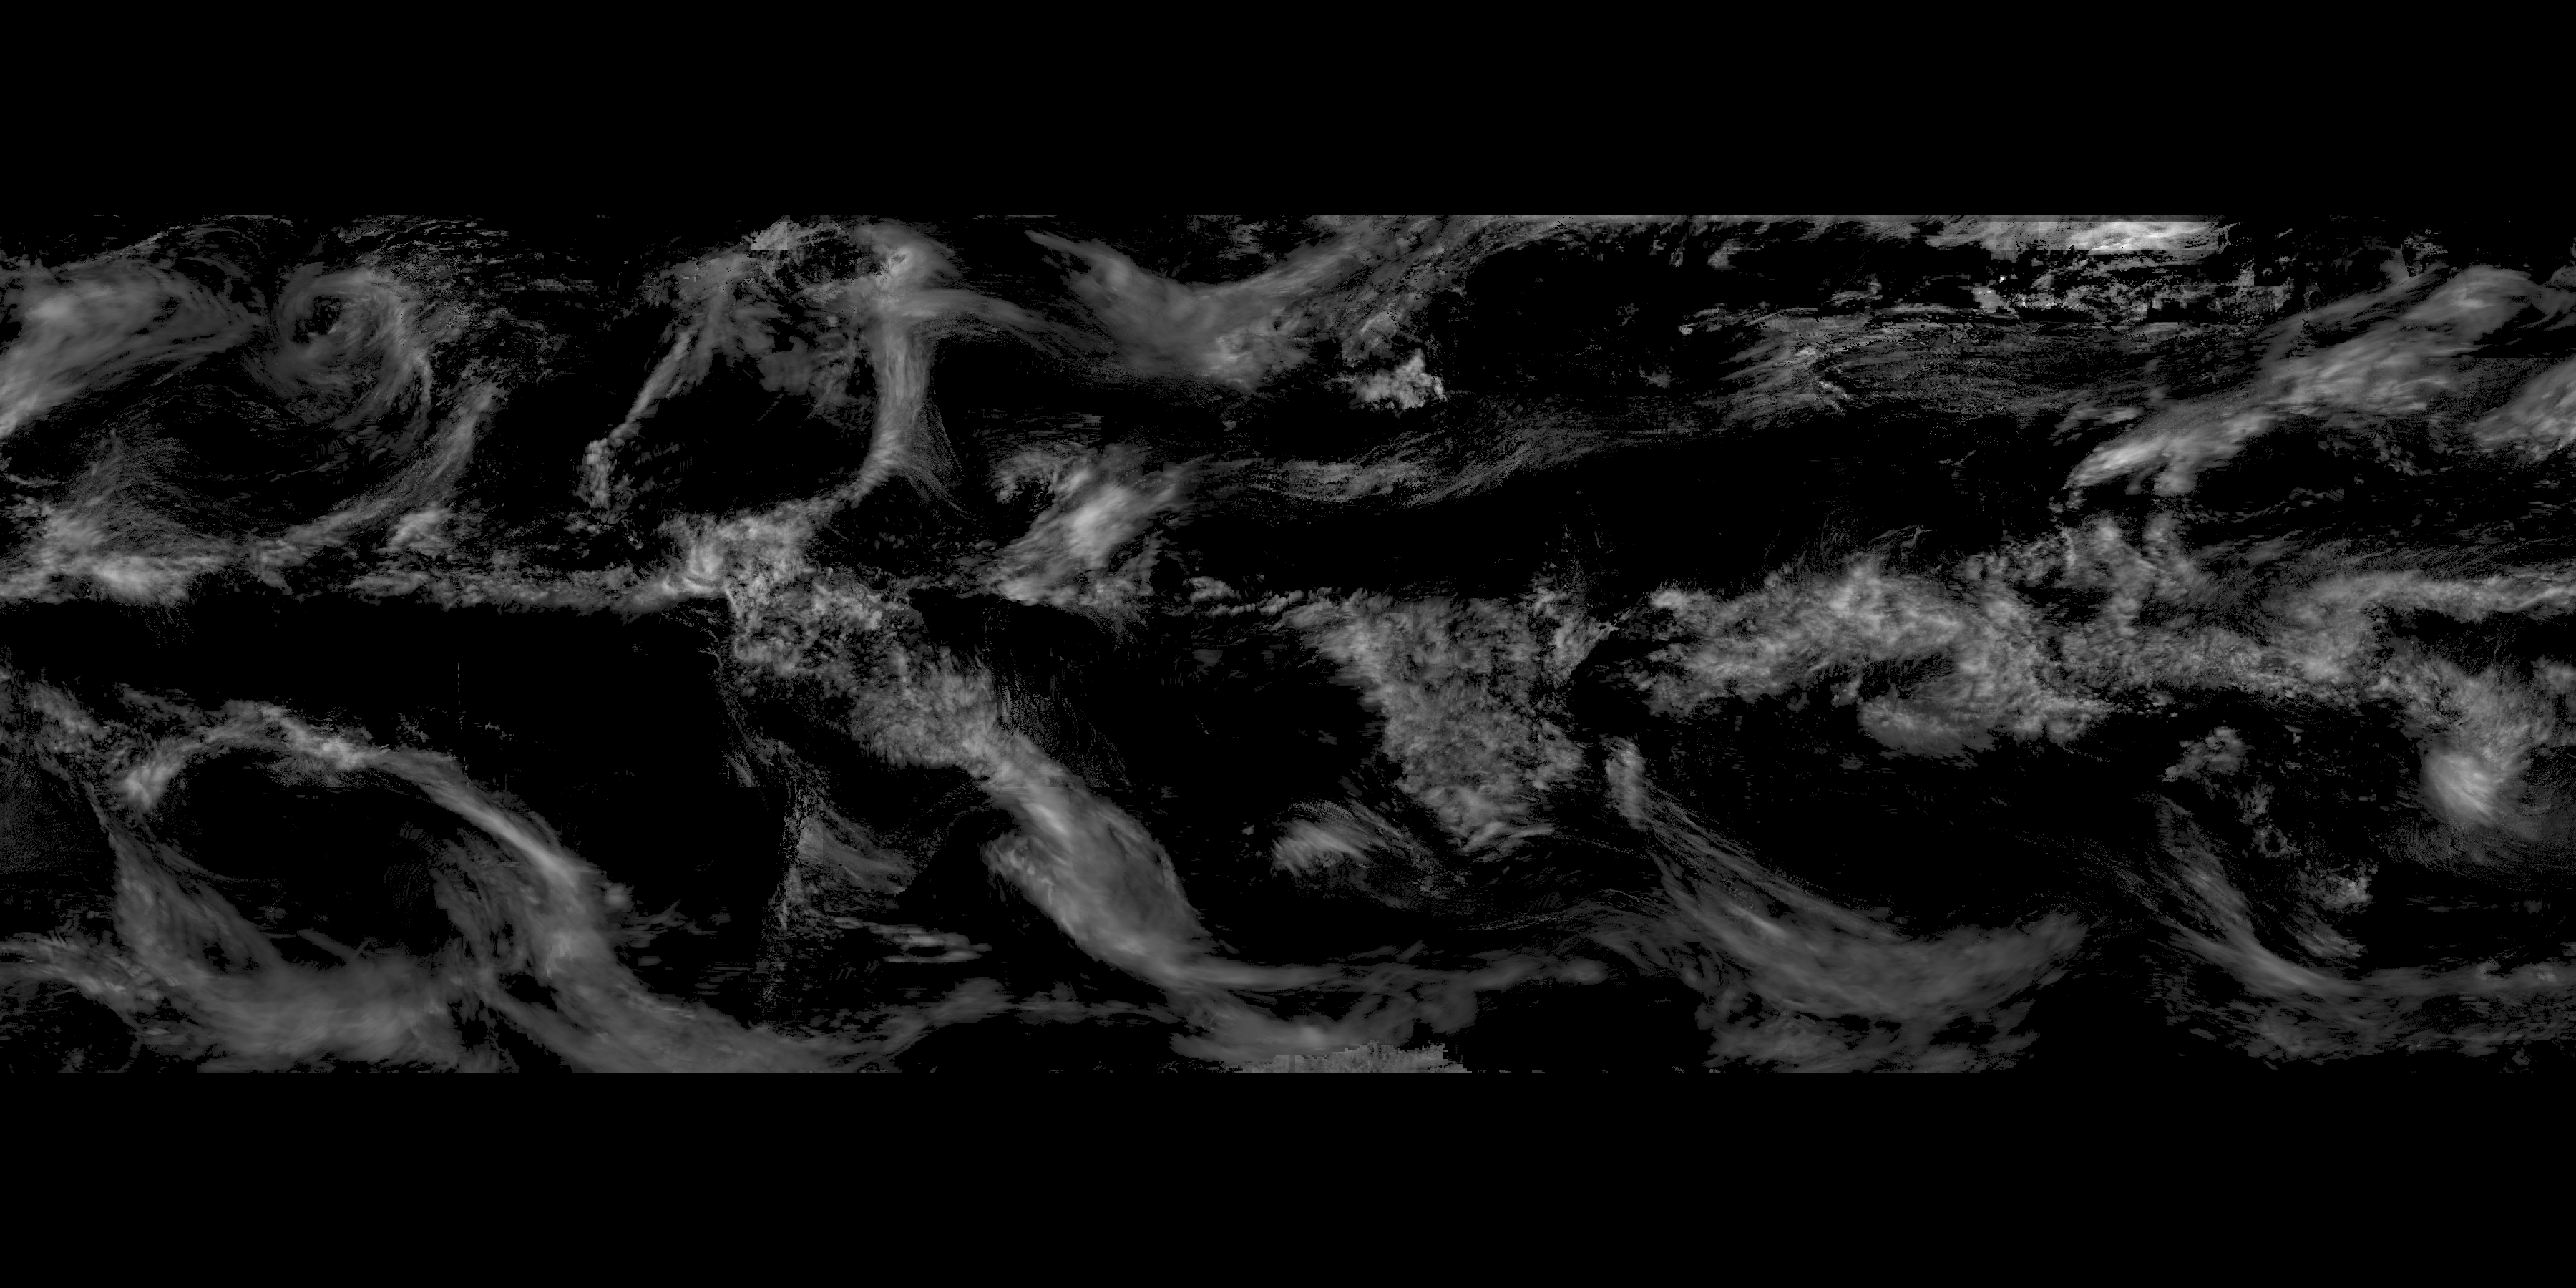

In [7]:
from PIL import Image, ImageDraw
# The movie here can be used for comparison:
# http://svs.gsfc.nasa.gov/cgi-bin/details.cgi?aid=4285
data = get_total_precipitation(
    datetime.datetime(2016, 11, 19),
    datetime.datetime(2016, 11, 21))
Image.fromarray(
    np.array((data.transpose()[::-1] / data.max())  ** .25 * 2 ** 8,
             dtype=np.uint8), 'L')

In [8]:
def zone_stats_helper(gpshapes, raster, lats, lons):
    data = raster.transpose()[::-1]
    xmin, ymin, xmax, ymax = [lons.min(), lats.min(), lons.max(), lats.max()]
    nrows,ncols = np.shape(data)
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    return zonal_stats(uganda_shapes, data,
        affine=Affine.from_gdal(xmin, xres, 0, ymax, 0, -yres),
        all_touched=True)

In [9]:
def plot_uganda_district_rainfall(rainfall_data):
    m = Basemap(projection='cyl',
                lat_0=45,
                lon_0=0,
                llcrnrlon=25, llcrnrlat=-5,
                urcrnrlon=38, urcrnrlat=10,
                resolution='l')
    fig = plt.figure(figsize=(10,10))
    m.pcolormesh(lons, lats, np.log(1+rainfall_data.transpose()), cmap=plt.cm.Blues, latlon=True)
    ax = plt.gca()
    patches = []
    #add polygons
    zstats = zone_stats_helper(uganda_shapes, rainfall_data, lats, lons)
    max_mean = max([stat['mean'] for stat in zstats])
    for idx, dist in uganda_shapes.iterrows():
        poly = dist.geometry
        stats = zstats[idx]
        if poly.geom_type == 'Polygon':
            p = PolygonPatch(poly, facecolor=plt.cm.BuGn((stats['mean'] / max_mean) ** .25), alpha=.3)
            patches.append(p)
    ax.add_collection(mpl.collections.PatchCollection(patches, match_original=True))
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    return m

/home/nathan/venvs/main/local/lib/python2.7/site-packages/rasterstats/io.py:291: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


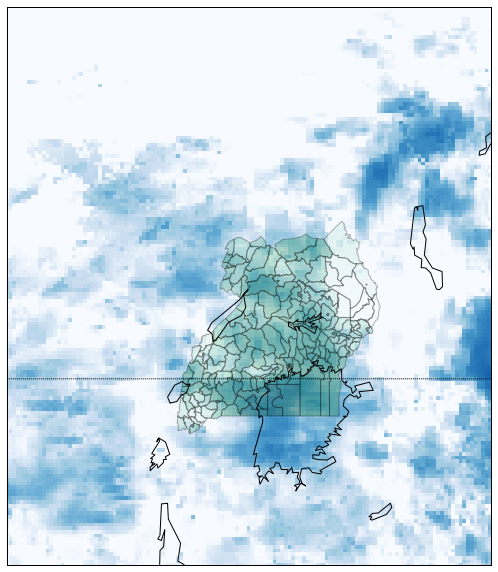

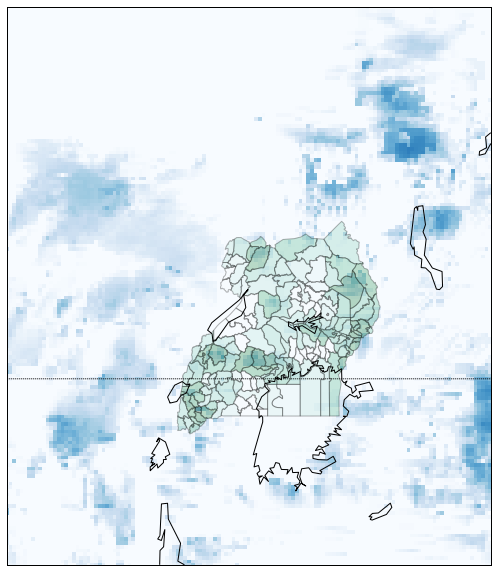

In [10]:
data = get_total_precipitation(datetime.datetime(2016, 11, 19), datetime.datetime(2016, 11, 20))
print(plot_uganda_district_rainfall(data))
data = get_total_precipitation(datetime.datetime(2016, 11, 20), datetime.datetime(2016, 11, 21))
print(plot_uganda_district_rainfall(data))
#TODO: Check raster alignment

In [14]:
timeseries = []
for day in pd.date_range('3/13/2016', '11/20/2016', freq='D'):
    data = get_total_precipitation(
        pd.to_datetime(day),
        pd.to_datetime(day) + datetime.timedelta(1))
    #print day
    print(".", end='')
    zstats = zone_stats_helper(uganda_shapes, data, lats, lons)
    for idx, row in uganda_shapes.iterrows():
        zstats[idx]['ADM_NAME'] = row.ADM1_NAME + '.' + row.ADM2_NAME
        zstats[idx]['date'] = day
    timeseries.extend(zstats)
#Unable to open file (Unable to open file: name = '/home/nathan/gpm/201603/3b-hhr-e.ms.mrg.3imerg.20160312-s120000-e122959.0720.v03e.rt-h5'
# Looks like missing data from 12 to 3pm

.............................................................................................................................................................................................................................................................

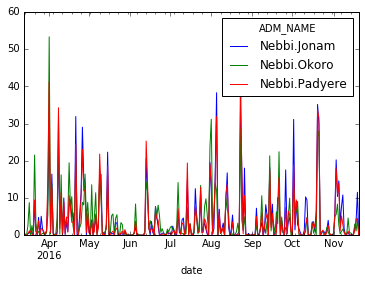

In [15]:
#http://earthpy.org/pandas-basics.html
d = pd.DataFrame(timeseries)
d = d[d.ADM_NAME.str.startswith('Nebbi')]
d.groupby(['ADM_NAME', 'date']).max().reset_index().pivot(
    index='date', columns='ADM_NAME', values='mean'
).plot()

# Useful links:
https://github.com/geopandas/geopandas/blob/master/examples/choropleths.ipynb
https://github.com/davidbrochart/gross/blob/8c1111b87b87b57fa3462abb1a19bb95d94ccac1/ipynb/amazon1.ipynb
https://github.com/JacksonTanBS/iPythonNotebooks/blob/master/150528%20How%20Much%20of%20Earth%20is%20Raining%20at%20Any%20One%20Time.ipynb
